## LIGHTBGM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import pickle
import os
from datetime import timedelta

#### Load and preprocess data

In [2]:
print("Loading dataset...")
df = pd.read_csv("TransformedData.csv")
df['Posted Time'] = pd.to_datetime(df['Posted Time'], format="%d/%m/%Y")
print(f"Dataset shape: {df.shape}")
print(df.head())

Loading dataset...
Dataset shape: (15818, 38)
  Posted Time     Width    Length  Floors  Rooms  Toilets  Price per m2  \
0  2025-01-31  2.236068  4.472136     0.0    0.0      0.0      1.647231   
1  2025-02-01  2.236068  4.472136     0.0    0.0      0.0      1.647231   
2  2025-01-13  2.236068  3.872983     0.0    0.0      0.0      2.027921   
3  2025-02-07  2.236068  5.477226     0.0    0.0      0.0      1.723356   
4  2025-02-02  2.236068  4.472136     0.0    0.0      0.0      2.312438   

   1 Part Residential  All Residential  Back Expansion  ...  \
0                   1                0               1  ...   
1                   0                0               1  ...   
2                   0                0               0  ...   
3                   1                0               0  ...   
4                   0                0               1  ...   

   House Direction_SOUTHWEST  House Direction_WEST  \
0                        0.0                   0.0   
1               

In [3]:
df['year'] = df['Posted Time'].dt.year
df['month'] = df['Posted Time'].dt.month
df['day'] = df['Posted Time'].dt.day
df['dayofweek'] = df['Posted Time'].dt.dayofweek
df['quarter'] = df['Posted Time'].dt.quarter

# Cyclical features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayOfWeek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayOfWeek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# Drop the datetime column after extracting features
df.drop(columns=['Posted Time'], inplace=True)

print("Feature engineering complete.")
print(df.info())

Feature engineering complete.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15818 entries, 0 to 15817
Data columns (total 46 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Width                               15818 non-null  float64
 1   Length                              15818 non-null  float64
 2   Floors                              15818 non-null  float64
 3   Rooms                               15818 non-null  float64
 4   Toilets                             15818 non-null  float64
 5   Price per m2                        15818 non-null  float64
 6   1 Part Residential                  15818 non-null  int64  
 7   All Residential                     15818 non-null  int64  
 8   Back Expansion                      15818 non-null  int64  
 9   Car Alley                           15818 non-null  int64  
 10  Frontage                            15818 non-null  int64  
 11  No Resident

#### Correlation analysis

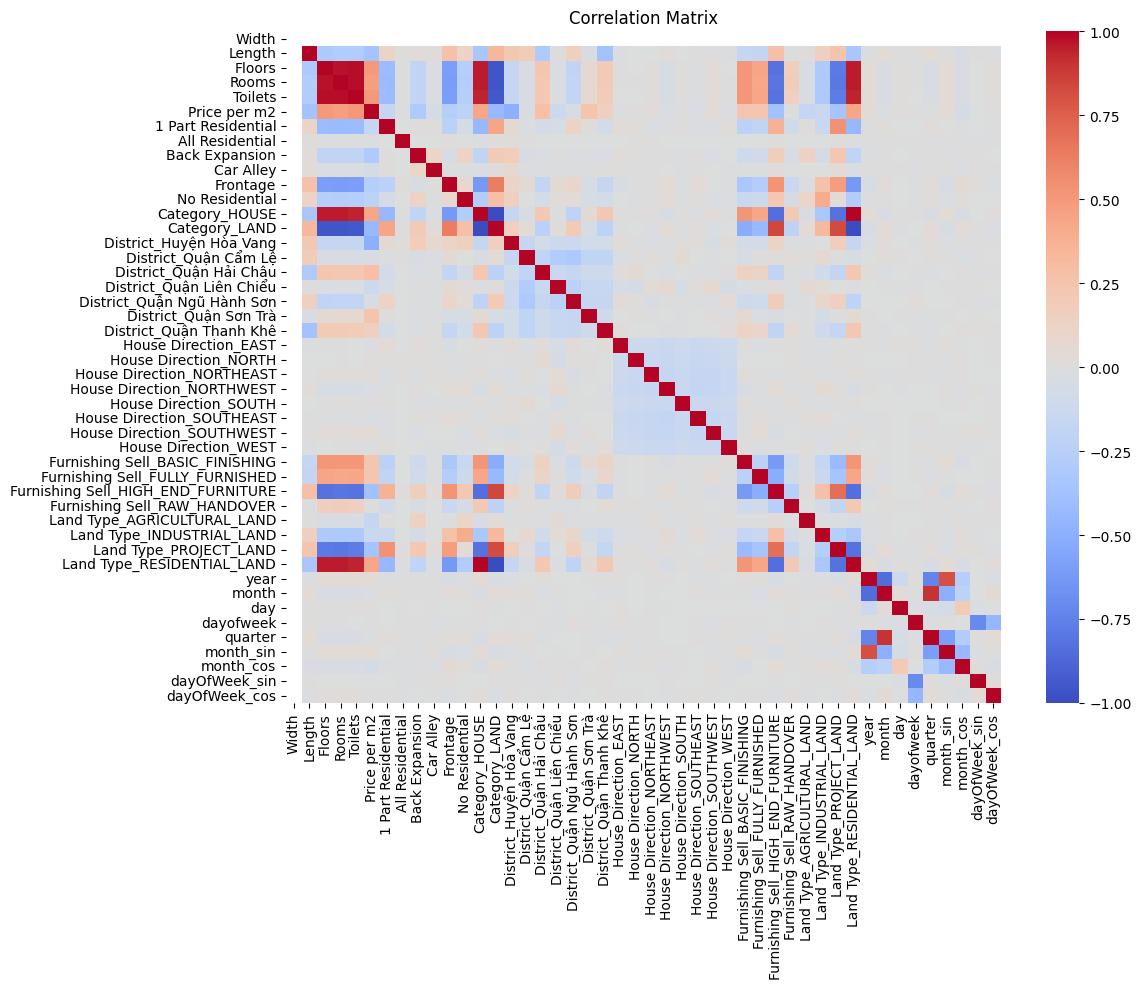

In [4]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()
plt.close()

In [5]:
corr_with_price = df.corr()['Price per m2'].abs().sort_values(ascending=False).drop('Price per m2')
print("Top 10 features correlated with Price per m2:\n", corr_with_price.head(10))

Top 10 features correlated with Price per m2:
 District_Huyện Hòa Vang               0.507049
Toilets                               0.500027
Floors                                0.499700
Rooms                                 0.476192
Category_LAND                         0.435878
Land Type_RESIDENTIAL_LAND            0.435878
Category_HOUSE                        0.435878
Furnishing Sell_HIGH_END_FURNITURE    0.379511
Length                                0.366774
Land Type_PROJECT_LAND                0.352890
Name: Price per m2, dtype: float64


In [6]:
y = df['Price per m2']
X = df.drop('Price per m2', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=26
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (12654, 45), X_test: (3164, 45)


#### Basic LightGBM model

In [7]:
print("\nTraining basic LightGBM model...")
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'rmse'},
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

basic_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[lgb.early_stopping(10)]
)


Training basic LightGBM model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	training's l2: 0.0991029	training's rmse: 0.314806	valid_1's l2: 0.100672	valid_1's rmse: 0.317288


#### Evaluate basic model

In [8]:
y_train_pred = basic_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on Test Set
y_test_pred = basic_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== Basic LightGBM Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.5f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.5f}")

=== Basic LightGBM Evaluation ===
Training MSE: 0.09910, RMSE: 0.31481, MAE: 0.23046, R2: 0.70113
Test MSE: 0.10067, RMSE: 0.31729, MAE: 0.23426, R2: 0.66562


#### Plot actual vs predicted

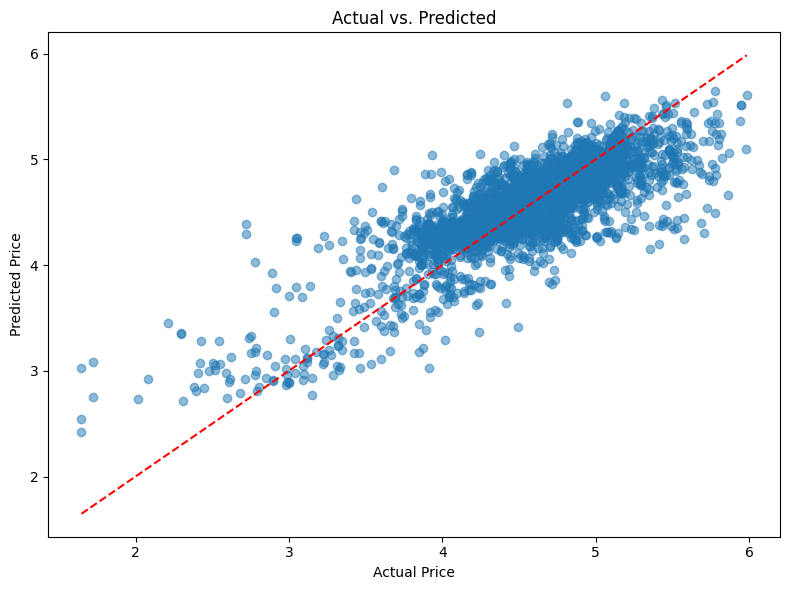

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.show()
plt.close()

#### Feature importance

<Figure size 1000x800 with 0 Axes>

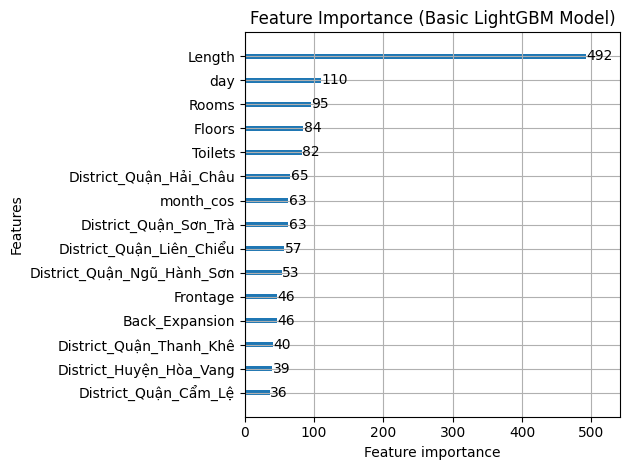

In [10]:
plt.figure(figsize=(10,8))
lgb.plot_importance(basic_model, max_num_features=15)
plt.title("Feature Importance (Basic LightGBM Model)")
plt.tight_layout()
plt.show()
plt.close()

In [11]:
# # 9. Hyperparameter tuning
# print("\nPerforming hyperparameter tuning for LightGBM...")
# param_grid = {
#     'num_leaves': [31, 50, 70],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 200, 300],
#     'min_child_samples': [20, 30, 50],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }

# lgbm_estimator = lgb.LGBMRegressor(objective='regression', random_state=26)
# grid = GridSearchCV(
#     lgbm_estimator,
#     param_grid,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     verbose=1,
#     n_jobs=-1
# )

# grid.fit(X_train, y_train)
# print("Best parameters:", grid.best_params_)

# # Performing hyperparameter tuning for LightGBM...
# # Fitting 5 folds for each of 729 candidates, totalling 3645 fits
# # [LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
# # Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_samples': 30, 'n_estimators': 200, 'num_leaves': 70, 'subsample': 0.8}

In [12]:
# # 10. Evaluate optimized model
# best_model = grid.best_estimator_
# y_pred_best = best_model.predict(X_test)

# mse_b = mean_squared_error(y_test, y_pred_best)
# rmse_b = np.sqrt(mse_b)
# mae_b = mean_absolute_error(y_test, y_pred_best)
# r2_b = r2_score(y_test, y_pred_best)

# print("\n=== Optimized LightGBM Model Evaluation ===")
# print(f"MSE: {mse_b:.5f}, RMSE: {rmse_b:.5f}, MAE: {mae_b:.5f}, R2: {r2_b:.4f}")

In [13]:
best_params = {
    'colsample_bytree': 0.9,
    'learning_rate': 0.05,
    'min_child_samples': 30,
    'n_estimators': 200,
    'num_leaves': 70,
    'subsample': 0.8,
    'objective': 'regression',
    'random_state': 42
}

best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on Test Set
y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\n=== Optimized LightGBM Model Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

=== Optimized LightGBM Model Evaluation ===
Training MSE: 0.07559, RMSE: 0.27494, MAE: 0.20011, R2: 0.7720
Test MSE: 0.09678, RMSE: 0.31109, MAE: 0.22802, R2: 0.6786


#### Plot actual vs predicted (optimized)

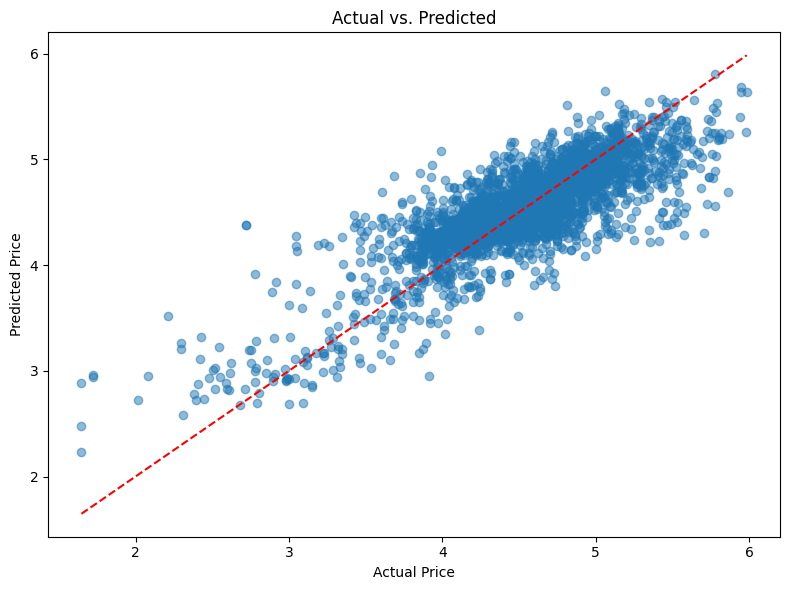

In [14]:

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.show()
plt.close()

#### Error analysis

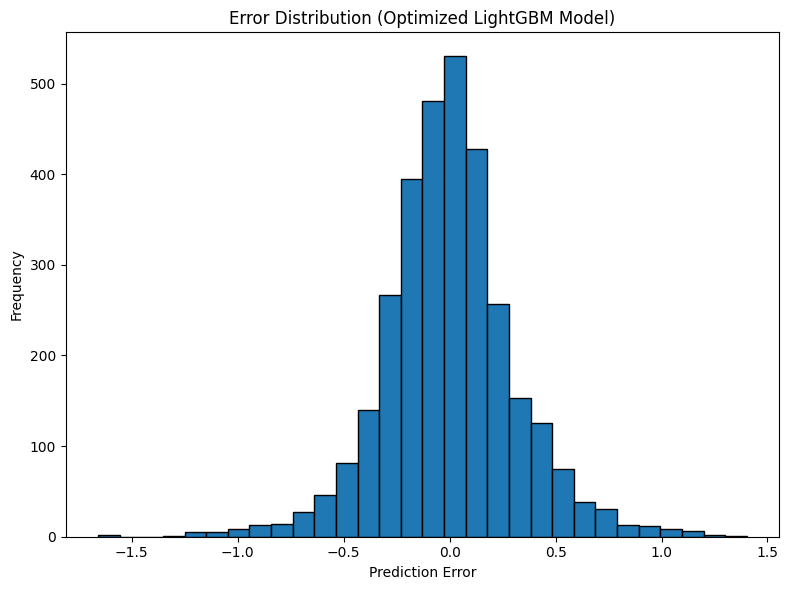

In [15]:
errors = y_test - y_test_pred
plt.figure(figsize=(8,6))
plt.hist(errors, bins=30, edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution (Optimized LightGBM Model)")
plt.tight_layout()
plt.show()
plt.close()

#### Cross-validation

In [16]:
cv_scores = cross_val_score(
    best_model, X_train, y_train,
    cv=5, scoring='neg_mean_squared_error'
)
print("\nCross-val MSE mean: {:.5f}, std: {:.5f}".format(-cv_scores.mean(), cv_scores.std()))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

Cross-val MSE mean: 0.11151, std: 0.00442


In [17]:
# # 14. Train final model on full dataset
# print("\nTraining final LightGBM model on full dataset...")
# final_model = lgb.LGBMRegressor(**grid.best_params_, objective='regression', random_state=26)
# final_model.fit(X, y)
# print("Training on full dataset complete.")
print("\nTraining final LightGBM model on full dataset...")

final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X, y)

print("Training on full dataset complete.")


Training final LightGBM model on full dataset...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training on full dataset complete.


#### Save models


In [18]:
with open('lightgbm_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Save to resource directory for potential backend use
output_dir = '../../Backend/src/main/resources/'
os.makedirs(output_dir, exist_ok=True)
with open(output_dir + 'lightgbm_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("Saved final model to lightgbm_final_model.pkl")

Saved final model to lightgbm_final_model.pkl


#### Generate forecast


Generating 90-day forecast...


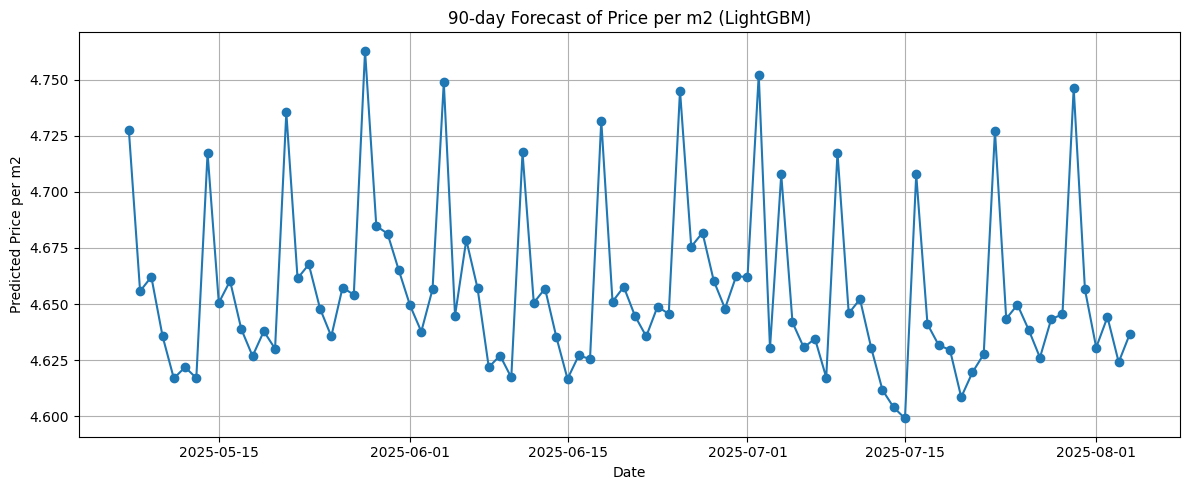

LightGBM model training and forecasting complete!


In [19]:
print("\nGenerating 90-day forecast...")
# Get baseline (latest sample)
base = X.iloc[-1].copy()

# Start date for forecasting (today)
start_date = pd.Timestamp.now().normalize()

# Generate forecasts
results = []
for i in range(90):
    date = start_date + timedelta(days=i)
    f = base.copy()
    
    # Update time features
    f['year'] = date.year
    f['month'] = date.month
    f['day'] = date.day
    f['dayofweek'] = date.weekday()
    f['quarter'] = date.quarter
    
    # cyclical features
    f['month_sin'] = np.sin(2 * np.pi * date.month / 12)
    f['month_cos'] = np.cos(2 * np.pi * date.month / 12)
    f['dayOfWeek_sin'] = np.sin(2 * np.pi * f['dayofweek'] / 7)
    f['dayOfWeek_cos'] = np.cos(2 * np.pi * f['dayofweek'] / 7)
    
    # Predict
    X_pred = f.values.reshape(1, -1)
    pred_price = final_model.predict(X_pred)[0]
    
    results.append({
        'Date': date,
        'LGBM_Predicted_Price_per_m2': pred_price
    })

forecast_df = pd.DataFrame(results)

# Save forecast results
forecast_df.to_csv('lightgbm_forecast_results.csv', index=False)

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(forecast_df['Date'], forecast_df['LGBM_Predicted_Price_per_m2'], marker='o')
plt.title('90-day Forecast of Price per m2 (LightGBM)')
plt.xlabel('Date')
plt.ylabel('Predicted Price per m2')
plt.grid(True)
plt.tight_layout()
plt.show()

print("LightGBM model training and forecasting complete!")